In [31]:
import numpy as np

class Perceptron:
    """Perceptron classifier.
    
    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight
        initialization.
    
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    errors_ : list
        Number of misclassifications (updates) in each epoch.
    
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1) -> None:
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of
            examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.
        
        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])

        self.b_ = np.float_(0.)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X,y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [32]:
import os
import pandas as pd

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

df = pd.read_csv(s, header=None, encoding='utf-8')
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Prep Data

In [33]:
# Select setosa and versicolor (we know the first 50 are setosa and second 50 are versicolor)
y = df.iloc[0:100, 4]

# convert to binary representation 1=setosa 0=versicolor
# these are the true labels
y = np.where(y == "Iris-setosa", 1, 0) 

# Select only the sepal length (1) and petal length (3), convert to numpy array
X = df.iloc[0:100, [0,2]].values

# Plot Data

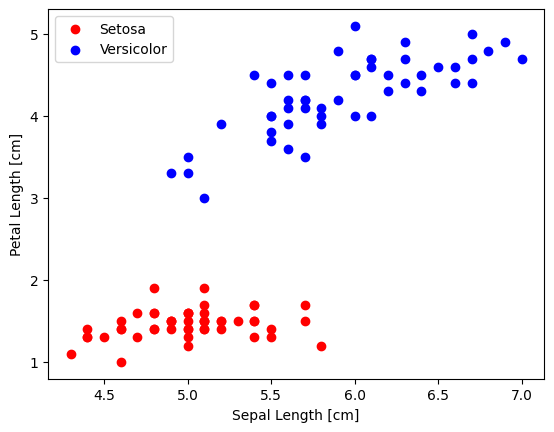

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(X[:50,0], X[:50,1], color='red', marker='o', label='Setosa')
plt.scatter(X[50:100,0], X[50:100,1], color='blue', marker='o', label='Versicolor')
plt.xlabel('Sepal Length [cm]')
plt.ylabel('Petal Length [cm]')
plt.legend(loc='upper left')
plt.show()

# Train Perceptron

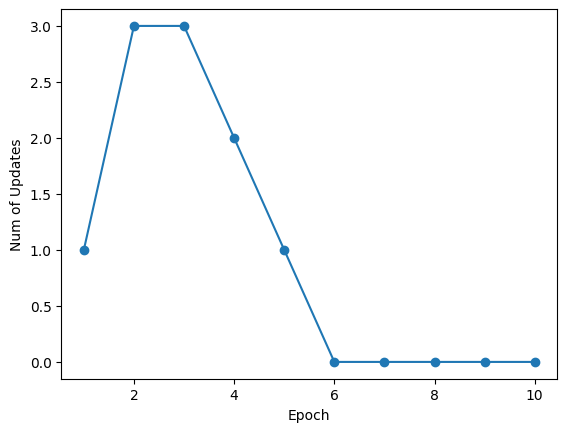

In [35]:
ppn = Perceptron(eta=0.1,n_iter=10)
ppn.fit(X,y)

# Plots the num of "errors" in labeling each epoch, note how it tapers at the end (indicating convergence)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Num of Updates")
plt.show()

In [36]:
# convenience functoin
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

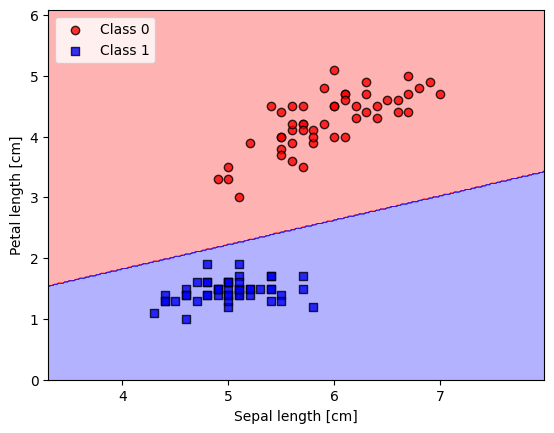

In [37]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Petal length [cm]')
plt.legend(loc='upper left')
plt.show()

# Adaline

In [38]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            
            #for w_j in range(self.w_.shape[0]):
            #    self.w_[w_j] += self.eta * (2.0 * (X[:, w_j]*errors)).mean()
            
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

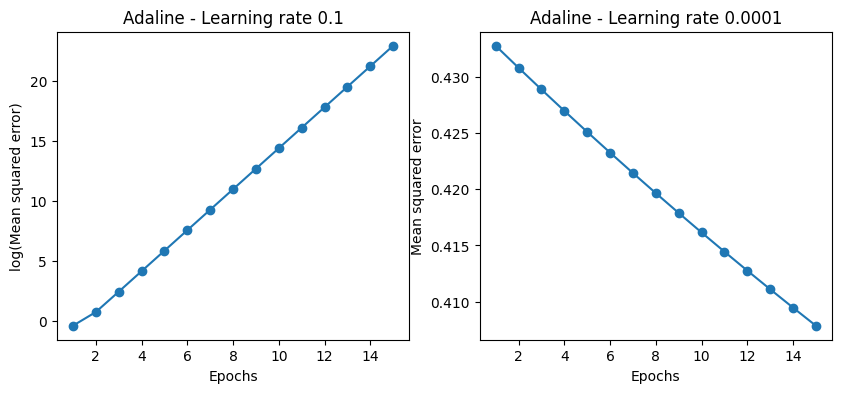

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)

ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

## Standardization

In [46]:
std_X = np.copy(X)
std_X[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
std_X[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

print(f"Original Sepal Length: mean={X[:, 0].mean()} sd={X[:, 0].std()}")
print(f"Standardized Sepal Length: mean={round(std_X[:, 0].mean())} sd={round(std_X[:, 0].std())}")
print(f"Original Petal Length: mean={X[:, 1].mean()} sd={X[:, 1].std()}")
print(f"Standardized Petal Length: mean={round(std_X[:, 1].mean())} sd={round(std_X[:, 1].std())}")

Original Sepal Length: mean=5.471000000000001 sd=0.6384817930058775
Standardized Sepal Length: mean=0 sd=1
Original Petal Length: mean=2.8620000000000005 sd=1.4413035766277695
Standardized Petal Length: mean=0 sd=1


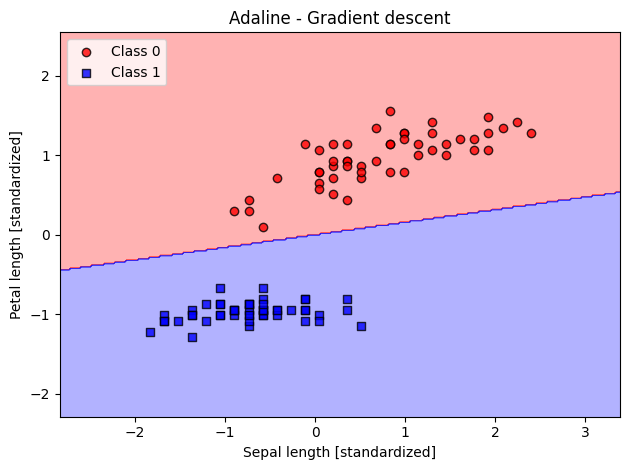

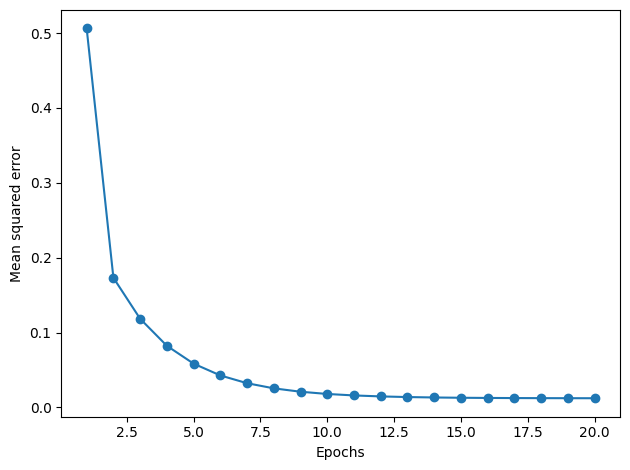

In [41]:
ada_gd = AdalineGD(n_iter=20, eta=0.5)
ada_gd.fit(std_X, y)

plot_decision_regions(std_X, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/02_14_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')

plt.tight_layout()
#plt.savefig('images/02_14_2.png', dpi=300)
plt.show()

## Stochastic Gradient Descent

In [50]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

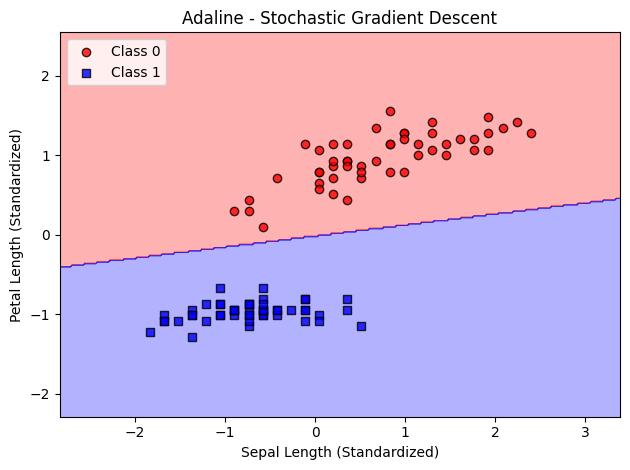

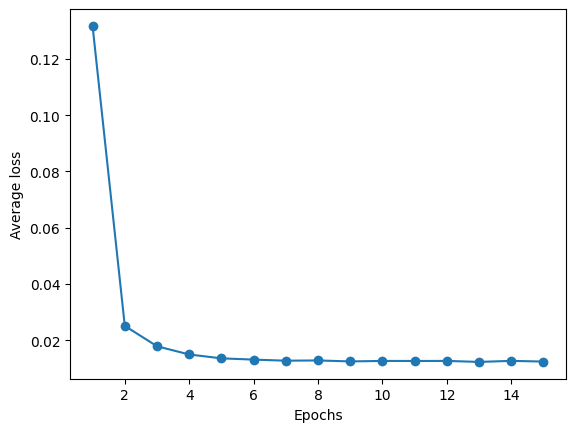

In [60]:
ada_sgd = AdalineSGD(eta=0.01, n_iter=15, random_state=1)
ada_sgd = ada_sgd.fit(std_X, y)

plot_decision_regions(std_X, y, ada_sgd)
plt.title("Adaline - Stochastic Gradient Descent")
plt.xlabel("Sepal Length (Standardized)")
plt.ylabel("Petal Length (Standardized)")
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('figures/02_15_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')

plt.savefig('figures/02_15_2.png', dpi=300)
plt.show()
